In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the root directories for training and testing data
train_dir = '/content/drive/MyDrive/DATA/seg_train/seg_train/'
test_dir = '/content/drive/MyDrive/DATA/seg_test/seg_test/'

# Define transformations (resize, convert to tensor, normalize)
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize images to 28x28
    transforms.ToTensor(),        # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize images (mean, std)
])

# Create datasets using ImageFolder
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Create DataLoaders
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check if datasets are loaded correctly
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")
print(f"Class-to-index mapping: {train_dataset.class_to_idx}")

# Example of how to get a batch of data
data_iter = iter(train_dataloader)
images, labels = next(data_iter)


print(f"Batch of images has shape: {images.shape}")
print(f"Batch of labels: {labels}")


Number of training samples: 13323
Number of testing samples: 2990
Class-to-index mapping: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
Batch of images has shape: torch.Size([64, 3, 28, 28])
Batch of labels: tensor([0, 3, 5, 2, 2, 5, 1, 5, 0, 1, 0, 4, 1, 4, 2, 3, 4, 1, 1, 4, 4, 0, 1, 0,
        1, 1, 2, 3, 5, 5, 4, 3, 3, 4, 1, 3, 4, 5, 5, 5, 1, 1, 4, 2, 5, 3, 1, 2,
        2, 0, 2, 5, 5, 5, 1, 2, 5, 3, 1, 1, 2, 5, 5, 2])


In [8]:
print(f"Batch of images has shape: {images.shape}")
print(f"Batch of labels has shape: {labels.shape}")
idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}


Batch of images has shape: torch.Size([64, 3, 28, 28])
Batch of labels has shape: torch.Size([64])


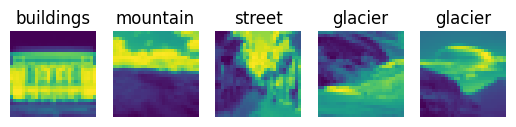

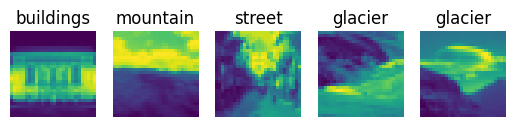

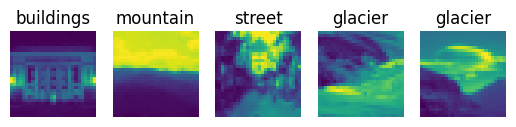

In [9]:

import matplotlib.pyplot as plt
import numpy as np

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i,0,:,:])
    plt.title(idx_to_class[labels[i].item()])
    plt.axis('off')
plt.show()

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i,1,:,:])
    plt.title(idx_to_class[labels[i].item()])
    plt.axis('off')
plt.show()

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i,2,:,:])
    plt.title(idx_to_class[labels[i].item()])
    plt.axis('off')
plt.show()


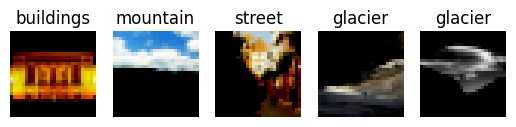

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Display the first 5 images with their labels using full RGB channels
for i in range(5):
    plt.subplot(1, 5, i+1)
    # Combine channels into RGB format
    img_rgb = images[i].permute(1, 2, 0).numpy()  # Convert to (height, width, channels)
    plt.imshow(img_rgb)
    plt.title(idx_to_class[labels[i].item()])
    plt.axis('off')
plt.show()


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [12]:
class Intel_Net(nn.Module):
    def __init__(self):
        super(Intel_Net, self).__init__()

        # Convolutional Layer 1: Input (3 channels, 28X28 pixels)
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3,  # Input channels (e.g., RGB color)
                      out_channels=32,  # Number of filters in this layer
                      kernel_size=3,    # Size of each filter (3x3)
                      stride=1,         # Stride (movement) of the filter
                      padding=1),       # Padding to maintain the input size
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))  # Activation function (Rectified Linear Unit)

        # Convolutional Layer 2: Input (32 channels, 28X28 pixels)
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32,  # Input channels from previous layer(out_channels)
                      out_channels=64,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))  # Activation function

        # Fully Connected Layer 1: Input (64 channels, 28X28 pixels)
        self.fc1 = nn.Linear(64 * 7 * 7, 64)  # Input size is flattened
        self.relu3 = nn.ReLU()

        # Fully Connected Layer 2: Input (64 units)
        self.fc2 = nn.Linear(64, 6)  # Output layer (4 classes)

    def forward(self, x):
        # Pass through first convolutional layer
        x = self.conv1(x)
        # Pass through second convolutional layer
        x = self.conv2(x)
        # Flatten the output from the convolutional layers
        x = x.view(x.size(0), -1)  # Flatten the tensor
        # Pass through first fully connected layer
        x = self.fc1(x)
        x = self.relu3(x)
        # Pass through second fully connected layer (output layer)
        x = self.fc2(x)
        output = F.softmax(x, dim=1)
        return output


In [13]:
new_model = Intel_Net()

In [14]:
count = 0
correct = 0

# Loop through all images in the dataset (adjust if the dataset is too large)
for i in range(min(10, len(images))):  # Here, only process first 10 images for testing
    X = images[i, :, :, :].view(1, 3, 28, 28).float()
    pred_probab = new_model(X)
    y_pred = pred_probab.argmax(1)

    print(f"Predicted class: {y_pred.item()}")
    print(f"Actual class: {labels[i].item()}")

    if y_pred.item() == labels[i].item():
        correct += 1

    count += 1

# Calculate and print the accuracy after the loop
accuracy = correct / count
print(f"Accuracy: {accuracy}")


Predicted class: 5
Actual class: 0
Predicted class: 5
Actual class: 3
Predicted class: 5
Actual class: 5
Predicted class: 5
Actual class: 2
Predicted class: 5
Actual class: 2
Predicted class: 5
Actual class: 5
Predicted class: 5
Actual class: 1
Predicted class: 5
Actual class: 5
Predicted class: 5
Actual class: 0
Predicted class: 5
Actual class: 1
Accuracy: 0.3


Predicted class: 5
Actual class: 0


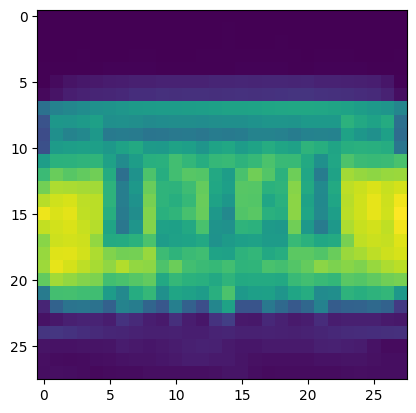

In [15]:
# X = images[0,0,:,:]
# print(X)
# X = images[0, 0, :, :].view(1, 1, 28, 28).float()
# print(X)
pred_probab = new_model(X)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred.item()}")
plt.imshow(images[0,1,:,:])
print(f"Actual class: {labels[0].item()}")

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
new_model.to(device)


Intel_Net(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=3136, out_features=64, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=64, out_features=6, bias=True)
)

In [17]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        # print(X)
        # print(batch)
        # print(y)
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

# Define the testing loop
def test_loop(dataloader, model, loss_fn):

    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [18]:
import torch.optim as optim
import torch.nn as nn

batch_size = 64
epochs = 5

# Initialize the optimizer with Adadelta
optimizer = optim.Adadelta(new_model.parameters())  # No need to set learning rate

# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

# Training loop
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loop(train_dataloader, new_model, loss_fn, optimizer)
    test_loop(test_dataloader, new_model, loss_fn)
print("Done!")


Epoch 1
-------------------------------
loss: 1.791750  [    0/13323]
loss: 1.559677  [ 6400/13323]
loss: 1.430378  [12800/13323]
Test Error: 
 Accuracy: 44.0%, Avg loss: 1.593745 

Epoch 2
-------------------------------
loss: 1.465666  [    0/13323]
loss: 1.436790  [ 6400/13323]
loss: 1.343423  [12800/13323]
Test Error: 
 Accuracy: 51.9%, Avg loss: 1.511222 

Epoch 3
-------------------------------
loss: 1.451450  [    0/13323]
loss: 1.443157  [ 6400/13323]
loss: 1.407071  [12800/13323]
Test Error: 
 Accuracy: 55.2%, Avg loss: 1.481310 

Epoch 4
-------------------------------
loss: 1.405291  [    0/13323]
loss: 1.383866  [ 6400/13323]
loss: 1.426158  [12800/13323]
Test Error: 
 Accuracy: 62.1%, Avg loss: 1.417083 

Epoch 5
-------------------------------
loss: 1.354046  [    0/13323]
loss: 1.394646  [ 6400/13323]
loss: 1.392591  [12800/13323]
Test Error: 
 Accuracy: 69.0%, Avg loss: 1.348653 

Done!


In [19]:
test_loop(train_dataloader, new_model, loss_fn)

Test Error: 
 Accuracy: 73.9%, Avg loss: 1.301810 



In [21]:
torch.save(new_model.state_dict(), '/content/model_weights.pth')

In [ ]:
loaded_model = Intel_Net()
loaded_model.load_state_dict(torch.load('/content/drive/MyDrive/INTEL_data_practice/with_convolution/optimiser_adadelta/model_weights.pth'))
loaded_model.eval()

Intel_Net(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (fc1): Linear(in_features=50176, out_features=64, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=64, out_features=6, bias=True)
)

In [ ]:
count = 0
correct =0
for i in range(10):
  X = images[i, :, :, :].view(1, 3, 28, 28).float()
  pred_probab = loaded_model(X)
  y_pred = pred_probab.argmax(1)
  print(f"Predicted class: {y_pred.item()}")
  print(f"Actual class: {labels[i].item()}")
  if(y_pred.item() == labels[i].item()):
    correct += 1
  count += 1
print(f"Accuracy: {correct/count}")



Predicted class: 0
Actual class: 0
Predicted class: 5
Actual class: 5
Predicted class: 3
Actual class: 3
Predicted class: 5
Actual class: 5
Predicted class: 1
Actual class: 1
Predicted class: 3
Actual class: 3
Predicted class: 5
Actual class: 5
Predicted class: 1
Actual class: 1
Predicted class: 0
Actual class: 4
Predicted class: 5
Actual class: 5
Accuracy: 0.9
